In [10]:
from collections import Counter

import os
import pandas as pd
import numpy as np
import sklearn
import scanpy as sc
import anndata
import shap
import subprocess
import umap

# import tensorflow as tf

import mgitools.os_helpers as os_helpers

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from pollock.models.model import embed_from_anndata, predict_from_anndata, load_from_directory, balancedish_training_generator
from pollock.models.explain import explain_predictions

In [5]:
adata = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/snRNAseq/ccrcc.h5ad')
module_fp = '../benchmarking/results/10272020_teir1/snRNAseq/ccrcc/pollock_module/'

In [8]:
specific = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_2/snRNAseq/ccrcc.h5ad')
# module_fp = '../benchmarking/results/10272020_teir1/snRNAseq/ccrcc/pollock_module/'
specific

AnnData object with n_obs × n_vars = 123794 × 33538
    obs: 'orig.ident_x', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'ident', 'aliqout_barcode', 'individual_barcode', 'orig.ident_y', 'Easy_id', 'Is_Normal_Nephron_Epithelium', 'is_malignant', 'Cell_type.shorter', 'Cell_type.detailed', 'Case', 'Sample_Type', 'Is_discovery_set', 'NMF.cluster', 'Immune.Group', 'snRNA_immune_subtype', 'Cell_group.detailed', 'doublet_score', 'predicted_doublet', 'is_doublet_scrublet', 'cell_type', 'sample_id'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [6]:
adata

AnnData object with n_obs × n_vars = 123250 × 33538
    obs: 'orig.ident_x', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'ident', 'aliqout_barcode', 'individual_barcode', 'orig.ident_y', 'Easy_id', 'Is_Normal_Nephron_Epithelium', 'is_malignant', 'Cell_type.shorter', 'Cell_type.detailed', 'Case', 'Sample_Type', 'Is_discovery_set', 'NMF.cluster', 'Immune.Group', 'snRNA_immune_subtype', 'Cell_group.detailed', 'doublet_score', 'predicted_doublet', 'is_doublet_scrublet', 'cell_type', 'sample_id'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


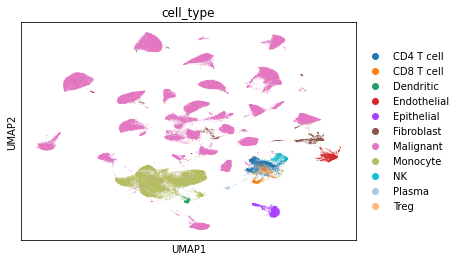

In [7]:
sc.pl.umap(adata, color='cell_type')

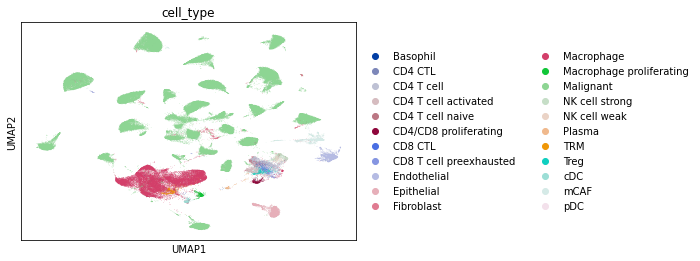

In [9]:
sc.pl.umap(specific, color='cell_type')

In [11]:
Counter(specific.obs['cell_type'])

Counter({'Malignant': 87773,
         'Macrophage': 20542,
         'mCAF': 1838,
         'Endothelial': 2232,
         'Fibroblast': 639,
         'TRM': 513,
         'CD4/CD8 proliferating': 466,
         'NK cell strong': 871,
         'CD8 T cell preexhausted': 141,
         'Plasma': 208,
         'CD4 T cell naive': 725,
         'Treg': 574,
         'NK cell weak': 409,
         'CD4 T cell': 1619,
         'CD8 CTL': 439,
         'Basophil': 31,
         'cDC': 447,
         'Macrophage proliferating': 466,
         'Epithelial': 2679,
         'CD4 T cell activated': 791,
         'CD4 CTL': 348,
         'pDC': 43})

In [22]:
both = sorted(set(adata.obs.index).intersection(set(specific.obs.index)))
len(both)

123250

In [23]:
genes = ['Macrophage', 'TRM', 'CD4/CD8 proliferating', 'NK cell strong', 'CD8 T cell preexhausted',
         'CD4 T cell naive', 'Treg', 'NK cell weak', 'CD4 T cell', 'CD8 CTL', 'Basophil', 'cDC',
          'Macrophage proliferating', 'CD4 T cell activated', 'CD4 CTL', 'pDC']
immune_specific = specific[both].copy()
immune_specific = immune_specific[[True if c in genes else False for c in immune_specific.obs['cell_type']]]

immune_specific

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 27881 × 33538
    obs: 'orig.ident_x', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'ident', 'aliqout_barcode', 'individual_barcode', 'orig.ident_y', 'Easy_id', 'Is_Normal_Nephron_Epithelium', 'is_malignant', 'Cell_type.shorter', 'Cell_type.detailed', 'Case', 'Sample_Type', 'Is_discovery_set', 'NMF.cluster', 'Immune.Group', 'snRNA_immune_subtype', 'Cell_group.detailed', 'doublet_score', 'predicted_doublet', 'is_doublet_scrublet', 'cell_type', 'sample_id'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [24]:
immune = adata[immune_specific.obs.index]
immune

View of AnnData object with n_obs × n_vars = 27881 × 33538
    obs: 'orig.ident_x', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'ident', 'aliqout_barcode', 'individual_barcode', 'orig.ident_y', 'Easy_id', 'Is_Normal_Nephron_Epithelium', 'is_malignant', 'Cell_type.shorter', 'Cell_type.detailed', 'Case', 'Sample_Type', 'Is_discovery_set', 'NMF.cluster', 'Immune.Group', 'snRNA_immune_subtype', 'Cell_group.detailed', 'doublet_score', 'predicted_doublet', 'is_doublet_scrublet', 'cell_type', 'sample_id'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


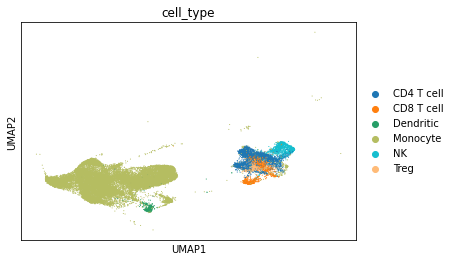

In [25]:
sc.pl.umap(immune, color='cell_type')

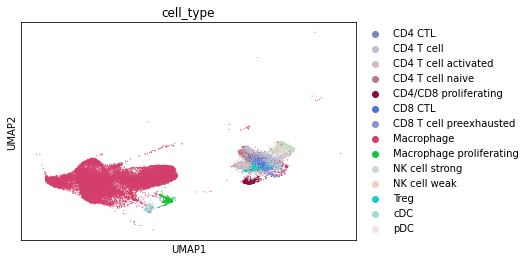

In [26]:
sc.pl.umap(immune_specific, color='cell_type')

In [27]:
predictions = predict_from_anndata(immune.copy(), module_fp)
predictions

2020-11-17 14:54:50,101 0 genes in training set are missing from prediction set
2020-11-17 14:54:51,807 starting batch 1 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-17 14:54:52,128 0 genes in training set are missing from prediction set
2020-11-17 14:55:25,391 starting batch 2 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-17 14:55:26,102 0 genes in training set are missing from prediction set
2020-11-17 14:55:57,170 starting batch 3 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-17 14:55:57,454 0 genes in training set are missing from prediction set


,predicted_cell_type,cell_type_probability,probability_CD4 T cell,probability_CD8 T cell,probability_Dendritic,probability_Endothelial,probability_Epithelial,probability_Fibroblast,probability_Malignant,probability_Monocyte,probability_NK,probability_Plasma,probability_Treg
AAACCCAAGAAGCTCG-1_9,Monocyte,0.91,0.00,0.00,0.04,0.00,0.00,0.04,0.00,0.91,0.00,0.01,0.00
AAACCCAAGACCAACG-1_4,Monocyte,0.67,0.01,0.04,0.03,0.02,0.02,0.10,0.03,0.67,0.02,0.04,0.02
AAACCCAAGAGTCCGA-1_29,Monocyte,0.81,0.04,0.01,0.05,0.01,0.00,0.00,0.00,0.81,0.04,0.00,0.04
AAACCCAAGTAGGAAG-1_4,NK,0.89,0.06,0.02,0.00,0.03,0.00,0.00,0.00,0.00,0.89,0.00,0.00
AAACCCAAGTGCACAG-1_24,Monocyte,0.89,0.00,0.01,0.02,0.05,0.00,0.00,0.02,0.89,0.00,0.01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCCATCACC-1_15,Monocyte,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
TTTGTTGTCCGCGGAT-1_27,Monocyte,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
TTTGTTGTCGCGGTAC-1_5,CD8 T cell,0.62,0.07,0.62,0.04,0.02,0.00,0.00,0.01,0.02,0.08,0.00,0.14
TTTGTTGTCGGAACTT-1_29,NK,0.94,0.02,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.94,0.00,0.02


In [28]:
immune.obs = pd.merge(immune.obs, predictions, right_index=True, left_index=True)
immune_specific.obs = pd.merge(immune_specific.obs, predictions, right_index=True, left_index=True)
immune.obs

,orig.ident_x,nCount_RNA,nFeature_RNA,percent.mito,RNA_snn_res.0.5,seurat_clusters,ident,aliqout_barcode,individual_barcode,orig.ident_y,...,probability_CD8 T cell,probability_Dendritic,probability_Endothelial,probability_Epithelial,probability_Fibroblast,probability_Malignant,probability_Monocyte,probability_NK,probability_Plasma,probability_Treg
AAACCCAAGAAGCTCG-1_9,CPT0010100001,5312.0,2313,0.098456,0,0,0,CPT0010100001_AAACCCAAGAAGCTCG-1,AAACCCAAGAAGCTCG-1,CPT0010100001,...,0.00,0.04,0.00,0.00,0.04,0.00,0.91,0.00,0.01,0.00
AAACCCAAGACCAACG-1_4,CPT0001220012,3455.0,1966,0.096671,0,0,0,CPT0001220012_AAACCCAAGACCAACG-1,AAACCCAAGACCAACG-1,CPT0001220012,...,0.04,0.03,0.02,0.02,0.10,0.03,0.67,0.02,0.04,0.02
AAACCCAAGAGTCCGA-1_29,CPT0086350004,1656.0,993,0.024155,0,0,0,CPT0086350004_AAACCCAAGAGTCCGA-1,AAACCCAAGAGTCCGA-1,CPT0086350004,...,0.01,0.05,0.01,0.00,0.00,0.00,0.81,0.04,0.00,0.04
AAACCCAAGTAGGAAG-1_4,CPT0001220012,1909.0,1211,0.086433,32,32,32,CPT0001220012_AAACCCAAGTAGGAAG-1,AAACCCAAGTAGGAAG-1,CPT0001220012,...,0.02,0.00,0.03,0.00,0.00,0.00,0.00,0.89,0.00,0.00
AAACCCAAGTGCACAG-1_24,CPT0075140002,9360.0,3583,0.020620,1,1,1,CPT0075140002_AAACCCAAGTGCACAG-1,AAACCCAAGTGCACAG-1,CPT0075140002,...,0.01,0.02,0.05,0.00,0.00,0.02,0.89,0.00,0.01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCCATCACC-1_15,CPT0020120013,1658.0,1136,0.032569,25,25,25,CPT0020120013_TTTGTTGTCCATCACC-1,TTTGTTGTCCATCACC-1,CPT0020120013,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
TTTGTTGTCCGCGGAT-1_27,CPT0078510004,2970.0,1790,0.000337,29,29,29,CPT0078510004_TTTGTTGTCCGCGGAT-1,TTTGTTGTCCGCGGAT-1,CPT0078510004,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
TTTGTTGTCGCGGTAC-1_5,CPT0001260013,1404.0,956,0.085470,38,38,38,CPT0001260013_TTTGTTGTCGCGGTAC-1,TTTGTTGTCGCGGTAC-1,CPT0001260013,...,0.62,0.04,0.02,0.00,0.00,0.01,0.02,0.08,0.00,0.14
TTTGTTGTCGGAACTT-1_29,CPT0086350004,1173.0,833,0.046888,32,32,32,CPT0086350004_TTTGTTGTCGGAACTT-1,TTTGTTGTCGGAACTT-1,CPT0086350004,...,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.94,0.00,0.02


In [29]:
embeddings = embed_from_anndata(immune.copy(), module_fp)
embeddings

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-17 14:57:59,170 0 genes in training set are missing from prediction set
2020-11-17 14:57:59,747 starting batch 1 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-17 14:57:59,989 0 genes in training set are missing from prediction set
2020-11-17 14:58:31,223 starting batch 2 of 3
2020-11-17 14:58:31,604 0 genes in training set are missing from prediction set
2020-11-17 14:59:02,727 starting batch 3 of 3
2020-11-17 14:59:03,052 0 genes in training set are missing from prediction set


,CELL_EMBEDDING_1,CELL_EMBEDDING_2,CELL_EMBEDDING_3,CELL_EMBEDDING_4,CELL_EMBEDDING_5,CELL_EMBEDDING_6,CELL_EMBEDDING_7,CELL_EMBEDDING_8,CELL_EMBEDDING_9,CELL_EMBEDDING_10,...,CELL_EMBEDDING_16,CELL_EMBEDDING_17,CELL_EMBEDDING_18,CELL_EMBEDDING_19,CELL_EMBEDDING_20,CELL_EMBEDDING_21,CELL_EMBEDDING_22,CELL_EMBEDDING_23,CELL_EMBEDDING_24,CELL_EMBEDDING_25
AAACCCAAGAAGCTCG-1_9,0.409389,0.031373,1.405506,-0.654865,0.565301,-2.357639,2.451807,1.196384,-4.268478,-0.654440,...,2.692276,-1.964175,1.285373,-1.304912,1.595981,-0.997756,-3.125113,1.852368,0.508705,-2.465770
AAACCCAAGACCAACG-1_4,0.161931,-0.213626,0.881784,-0.320009,0.407146,-2.059656,2.615240,1.067621,-2.977076,-0.552496,...,1.584137,-1.218038,0.911230,-1.233359,0.751484,-0.571659,-2.239098,1.650735,-0.428203,-2.040238
AAACCCAAGAGTCCGA-1_29,0.067823,-0.096087,0.432871,-0.061538,0.273164,-0.935634,1.121693,0.515281,-1.823138,-0.182807,...,0.833792,-0.585531,0.464362,-0.554622,0.486558,0.355023,-0.997539,0.687436,0.190543,-0.411467
AAACCCAAGTAGGAAG-1_4,0.030524,-0.869976,-0.608568,-0.445019,0.106908,-1.594405,1.122762,0.352294,-1.171511,0.616902,...,1.047920,-1.453514,1.148058,-1.010565,0.516823,-0.642456,-0.724679,0.910749,0.005451,-0.387675
AAACCCAAGTGCACAG-1_24,0.353354,-0.997732,0.447022,1.613755,0.722188,-7.286902,8.880902,2.595775,-9.029896,-2.402959,...,4.849153,-3.200869,3.092024,-3.010551,2.443520,1.504407,-6.205687,5.422274,-0.606607,-2.093230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCCATCACC-1_15,0.281808,-0.591551,0.542593,0.253403,0.052291,-1.554041,1.280850,0.737191,-1.468045,-0.376892,...,0.626545,-0.653849,0.228978,-0.836291,-0.001980,0.363075,-1.027143,0.901817,-0.165302,-0.694042
TTTGTTGTCCGCGGAT-1_27,0.473437,-0.405918,0.529694,-0.108087,-0.016276,-2.128642,2.594163,0.824401,-2.265771,-0.876975,...,1.611016,-1.403050,0.961152,-1.284366,0.695782,-0.178376,-1.828577,1.612918,-0.589960,-1.988184
TTTGTTGTCGCGGTAC-1_5,-0.062013,-0.534059,0.232110,-0.041034,0.573245,-1.372892,0.680338,0.203779,-0.752146,-0.068768,...,0.427846,-1.496105,0.672173,-0.422616,0.700544,-0.411890,-1.485094,0.437998,0.382019,-0.010142
TTTGTTGTCGGAACTT-1_29,-0.282777,-0.469327,-0.498885,-0.582263,0.307498,-1.148019,0.693268,0.179153,-0.784524,0.629228,...,0.667142,-0.878377,0.695630,-0.547188,0.299341,-0.585307,-0.288555,0.449425,0.015741,-0.105397


In [31]:
immune.obsm['X_embedding'] = embeddings.values
immune_specific.obsm['X_embedding'] = embeddings.values

from sklearn.preprocessing import StandardScaler
immune.obsm['X_umap_embedding'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(embeddings.values))
immune_specific.obsm['X_umap_embedding'] = immune.obsm['X_umap_embedding'].copy()

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical


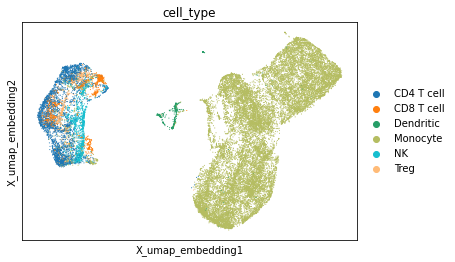

In [32]:
color = ['cell_type']
sc.pl.embedding(immune, basis='X_umap_embedding', color=color)

... storing 'predicted_cell_type' as categorical


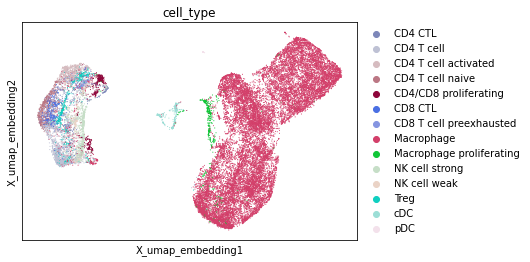

In [33]:
color = ['cell_type']
sc.pl.embedding(immune_specific, basis='X_umap_embedding', color=color)

In [37]:
explain, rest = balancedish_training_generator(immune_specific, cell_type_key='cell_type', n_per_cell_type=50,
                                        oversample=False, split=.8)
background, _ = balancedish_training_generator(rest, cell_type_key='cell_type', n_per_cell_type=50, oversample=False,
                                           split=1.)
explain_ids, background_ids = explain.obs.index.to_list(), background.obs.index.to_list()
explain, background = immune[explain_ids].copy(), immune[background_ids].copy()

explain.shape, background.shape

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


((684, 33538), (659, 33538))

In [38]:
Counter(explain.obs['cell_type'])

Counter({'NK': 100,
         'Dendritic': 84,
         'Monocyte': 100,
         'CD8 T cell': 150,
         'CD4 T cell': 200,
         'Treg': 50})

In [39]:
df = explain_predictions(explain.copy(), background.copy(), module_filepath=module_fp,
                    prediction_key='cell_type', )
df

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'aliqout_barcode' as categorical
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-17 16:24:57,122 0 genes in training set are missing from prediction set
2020-11-17 16:24:57,808 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-17 16:24:57,883 0 genes in training set are missing from prediction set
2020-11-17 16:25:00,400 0 genes in training set are missing from prediction set


,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
AAACCCAAGTAGGAAG-1_4,0.0,0.0,0.0,0.000170,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAGTTTGGGAG-1_4,0.0,0.0,0.0,0.000173,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000023,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCATCCTCACCA-1_4,0.0,0.0,0.0,0.000048,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000024,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGTAACAGT-1_29,0.0,0.0,0.0,0.000102,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCTGTTCTATCT-1_29,0.0,0.0,0.0,0.000023,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCGTTAGAGTA-1_24,0.0,0.0,0.0,0.000029,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000032,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGGAGCAAATACAG-1_7,0.0,0.0,0.0,0.000037,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000023,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGGTTAGCTGGAGT-1_22,0.0,0.0,0.0,0.000046,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000063,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGGTTAGTATGACA-1_22,0.0,0.0,0.0,0.000057,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000069,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
m1 = explain.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(m1)
sc.pp.highly_variable_genes(m1, n_top_genes=3000)
sc.pp.scale(m1)
sc.pp.neighbors(m1)
sc.pp.pca(m1)

sc.tl.umap(m1)
sc.tl.leiden(m1, resolution=.05)
m1

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


AnnData object with n_obs × n_vars = 684 × 33538
    obs: 'orig.ident_x', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'ident', 'aliqout_barcode', 'individual_barcode', 'orig.ident_y', 'Easy_id', 'Is_Normal_Nephron_Epithelium', 'is_malignant', 'Cell_type.shorter', 'Cell_type.detailed', 'Case', 'Sample_Type', 'Is_discovery_set', 'NMF.cluster', 'Immune.Group', 'snRNA_immune_subtype', 'Cell_group.detailed', 'doublet_score', 'predicted_doublet', 'is_doublet_scrublet', 'cell_type', 'sample_id', 'predicted_cell_type', 'cell_type_probability', 'probability_CD4 T cell', 'probability_CD8 T cell', 'probability_Dendritic', 'probability_Endothelial', 'probability_Epithelial', 'probability_Fibroblast', 'probability_Malignant', 'probability_Monocyte', 'probability_NK', 'probability_Plasma', 'probability_Treg', 'leiden'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersi

In [43]:
explain_ids

['AAACCCAAGTAGGAAG-1_4',
 'AAACCCAGTTTGGGAG-1_4',
 'AAACCCATCCTCACCA-1_4',
 'AAACGAAAGTAACAGT-1_29',
 'AAACGCTGTTCTATCT-1_29',
 'AAAGGATAGAGGTCAC-1_15',
 'AAAGGATCAACCGACC-1_27',
 'AAAGGATGTGGCATCC-1_10',
 'AAAGTCCTCTCTCTAA-1_23',
 'AAATGGACAGAACCGA-1_12',
 'AAATGGAGTTACACAC-1_15',
 'AACAAAGTCGCGCCAA-1_22',
 'AACAACCTCCTACGAA-1_24',
 'AACACACCAATGCAAA-1_23',
 'AACAGGGAGCGTGCTC-1_5',
 'AACCAACTCATCCTGC-1_13',
 'AACCACATCGGAACTT-1_10',
 'AACCATGCAGCGGTTC-1_15',
 'AACCTGAAGCACCCAC-1_11',
 'AACCTTTAGATCCCAT-1_7',
 'AACCTTTCAATGAAAC-1_7',
 'AACCTTTTCTGCCCTA-1_7',
 'AACGTCAAGTAGAGTT-1_9',
 'AACGTCACAGATACTC-1_7',
 'AACTTCTTCACCACAA-1_21',
 'AACTTCTTCAGCGCAC-1_24',
 'AAGATAGGTCAATGGG-1_13',
 'AAGATAGGTTAATCGC-1_10',
 'AAGCATCAGACCATTC-1_22',
 'AAGCATCTCCTTGGAA-1_28',
 'AAGGTAAGTCTAGATC-1_7',
 'AAGTCGTAGAGCATTA-1_29',
 'AAGTGAAAGGGCCCTT-1_24',
 'AAGTGAATCCATCACC-1_15',
 'AAGTGAATCGCAGTTA-1_5',
 'AATGAAGGTGGCTAGA-1_13',
 'AATGCCACAGGTCTCG-1_17',
 'AATGGCTAGCCTTCTC-1_10',
 'AATGGCTAGTACAGCG-1_17

In [47]:
m1.obs['cell_type_specific'] = immune_specific[explain_ids].obs['cell_type'].to_list()

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'cell_type_specific' as categorical


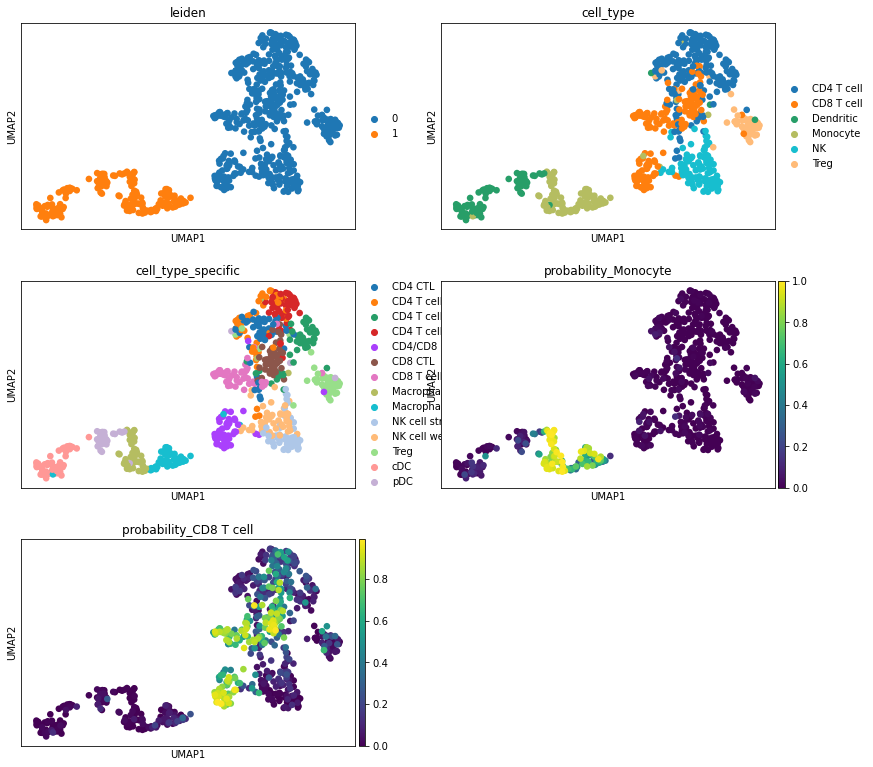

In [48]:
sc.pl.umap(m1, color=['leiden', 'cell_type', 'cell_type_specific', 
                      'probability_Monocyte', 'probability_CD8 T cell'],
          ncols=2)

In [49]:
# grab the ductal
combined = anndata.AnnData(X=df.values)
combined.var.index = list(df.columns)
combined.obs.index = df.index.to_list()
combined.obs = pd.merge(combined.obs, explain.obs, right_index=True, left_index=True)
combined

AnnData object with n_obs × n_vars = 684 × 33538
    obs: 'orig.ident_x', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'ident', 'aliqout_barcode', 'individual_barcode', 'orig.ident_y', 'Easy_id', 'Is_Normal_Nephron_Epithelium', 'is_malignant', 'Cell_type.shorter', 'Cell_type.detailed', 'Case', 'Sample_Type', 'Is_discovery_set', 'NMF.cluster', 'Immune.Group', 'snRNA_immune_subtype', 'Cell_group.detailed', 'doublet_score', 'predicted_doublet', 'is_doublet_scrublet', 'cell_type', 'sample_id', 'predicted_cell_type', 'cell_type_probability', 'probability_CD4 T cell', 'probability_CD8 T cell', 'probability_Dendritic', 'probability_Endothelial', 'probability_Epithelial', 'probability_Fibroblast', 'probability_Malignant', 'probability_Monocyte', 'probability_NK', 'probability_Plasma', 'probability_Treg'

In [51]:
feature_adata = combined.copy()
sc.pp.highly_variable_genes(feature_adata, n_top_genes=3000)
# highly_variable = feature_adata.var['highly_variable'].to_list()
feature_adata = combined.copy()
# feature_adata.X = np.log1p(feature_adata.X * 100)
sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata)
sc.pp.pca(feature_adata)

sc.tl.umap(feature_adata)
sc.tl.leiden(feature_adata, resolution=.2)
feature_adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 684 × 33538
    obs: 'orig.ident_x', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.0.5', 'seurat_clusters', 'ident', 'aliqout_barcode', 'individual_barcode', 'orig.ident_y', 'Easy_id', 'Is_Normal_Nephron_Epithelium', 'is_malignant', 'Cell_type.shorter', 'Cell_type.detailed', 'Case', 'Sample_Type', 'Is_discovery_set', 'NMF.cluster', 'Immune.Group', 'snRNA_immune_subtype', 'Cell_group.detailed', 'doublet_score', 'predicted_doublet', 'is_doublet_scrublet', 'cell_type', 'sample_id', 'predicted_cell_type', 'cell_type_probability', 'probability_CD4 T cell', 'probability_CD8 T cell', 'probability_Dendritic', 'probability_Endothelial', 'probability_Epithelial', 'probability_Fibroblast', 'probability_Malignant', 'probability_Monocyte', 'probability_NK', 'probability_Plasma', 'probability_Treg', 'leiden'
    var: 'mean', 'std'
    uns: 'neighbors', 'pca', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connect

In [54]:
feature_adata.obs['cell_type_specific'] = immune_specific[explain_ids].obs['cell_type'].to_list()

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


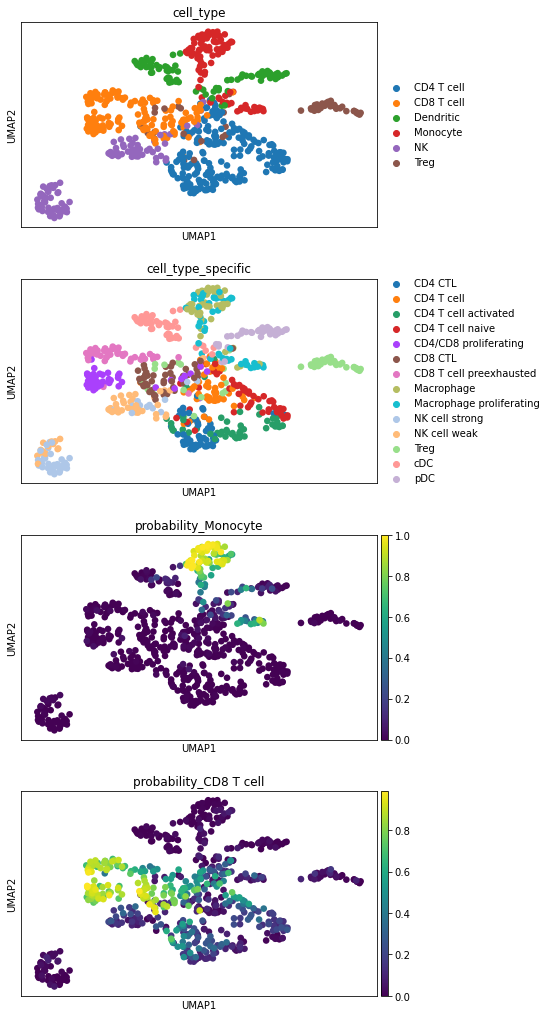

In [57]:
sc.pl.umap(feature_adata, color=['cell_type', 'cell_type_specific',
                                 'probability_Monocyte', 'probability_CD8 T cell'],
          ncols=1)

In [58]:
m1.obsm['X_umap_feature'] = feature_adata.obsm['X_umap'].copy()

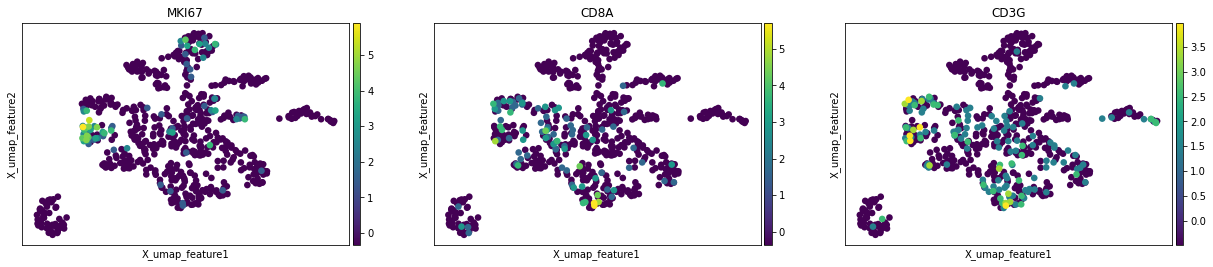

In [62]:
genes = ['MKI67', 'CD8A', 'CD3G']
sc.pl.embedding(m1, basis='X_umap_feature', color=genes)

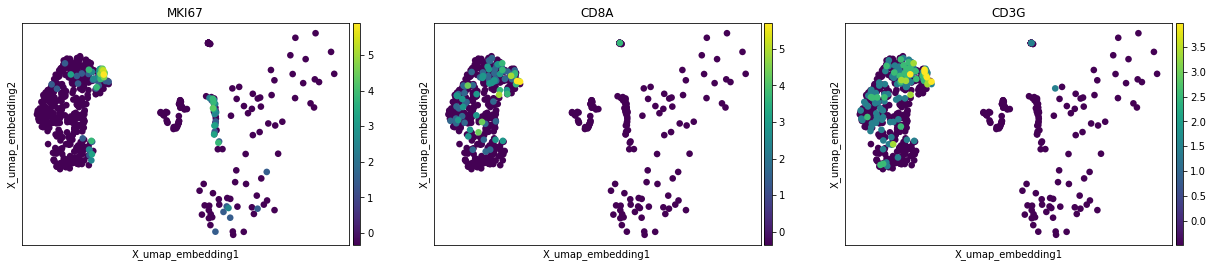

In [63]:
sc.pl.embedding(m1, basis='X_umap_embedding', color=genes)

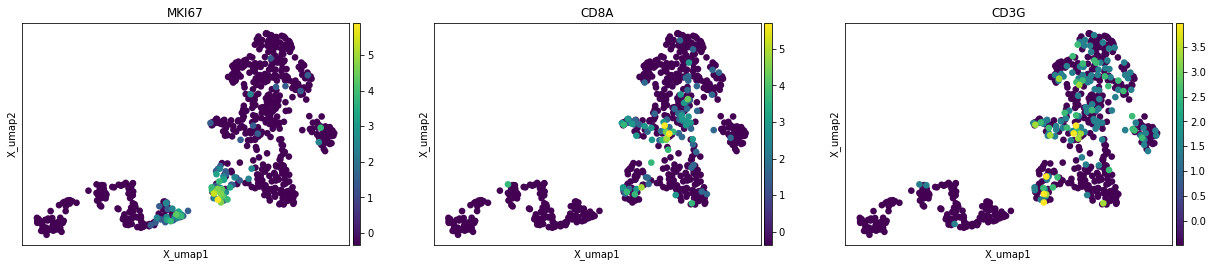

In [64]:
sc.pl.embedding(m1, basis='X_umap', color=genes)